# FFT

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/notebooks/fft.ipynb)

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/DSIRP/raw/main/timing.py')

In [2]:
from timing import run_timing_test, plot_timing_test

## Discrete Fourier Transform

According to our friends at [Wikipedia](https://en.wikipedia.org/wiki/Discrete_Fourier_transform):

> The discrete Fourier transform transforms a sequence of $N$ complex numbers 
${\displaystyle \mathbf{x} =x_{0},x_{1},\ldots ,x_{N-1}}$ into another sequence of complex numbers, 
${\displaystyle \mathbf{X} =X_{0},X_{1},\ldots ,X_{N-1},}$ which is defined by $$X_k = \sum_{n=0}^N x_n \cdot e^{-i 2 \pi k n / N} $$ 

Notice:

* $X$ and $x$ are the same length, $N$.

* $n$ is the index that specifies an element of $x$, and 

* $k$ is the index that specifies an element of $X$.

Let's start with a small example and use Numpy's implementation of FFT to compute the DFT.

In [3]:
x = [1, 0, 0, 0]

In [4]:
import numpy as np

np.fft.fft(x)

array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

Now we know what the answer is, let's compute it ourselves.

Here's the expression that computes one element of $X$.

In [5]:
pi = np.pi
exp = np.exp
N = len(x)
k = 0

In [6]:
sum(x[n] * exp(-2j * pi * k * n / N) for n in range(N))

(1+0j)

Wrapping this code in a function makes the roles of `k` and `n` clearer:

* `k` is the parameter that specifies which element of the DFT to compute, and 

* `n` is the loop variable we use to compute the summation.

In [7]:
def dft_k(x, k):
    N = len(x)
    return sum(x[n] * exp(-2j * pi * k * n / N) for n in range(N))

In [8]:
dft_k(x, k=1)

(1+0j)

Usually we compute $X$ all at once, so we can wrap `dft_k` in another function:

In [9]:
def dft(x):
    N = len(x)
    X = [dft_k(x, k) for k in range(N)]
    return X

In [10]:
dft(x)

[(1+0j), (1+0j), (1+0j), (1+0j)]

And that's what we got from Numpy.

## Timing DFT

Let's see what the performance of `dft` looks like.

In [11]:
def test_dft(N):
    x = np.random.normal(size=N)
    X = dft(x)

In [12]:
%time test_dft(512)

CPU times: user 772 ms, sys: 44 µs, total: 772 ms
Wall time: 772 ms


32 0.010000000000000231
64 0.009999999999999787
128 0.050000000000000266
256 0.18999999999999995
512 0.79
1024 3.1799999999999993


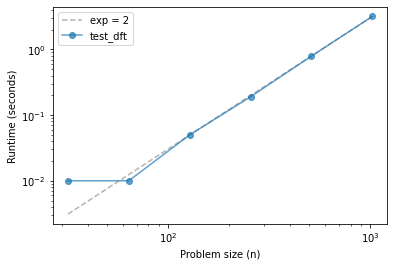

In [13]:
ns, ts = run_timing_test(test_dft, start_at=5)
plot_timing_test(ns, ts, 'test_dft', exp=2)

## Implementing FFT

The key to the FFT algorithm is the [Danielson-Lanczos lemma](https://mathworld.wolfram.com/Danielson-LanczosLemma.html), which says

$ X_k = E_k + e^{-i 2 \pi n / N} O_k $

Where 

* $E$ is the FFT of the even elements of $x$, and

* $O$ is the DFT of the odd elements of $x$.

Before we can translate this expression into code, we have to deal with a gotcha.

Remember that, if the length of $x$ is $N$, the length of $X$ is also $N$.

If we select the even elements of $x$, the result is a sequence with length $N/2$, which means that the length of $E$ is $N/2$.
And the same for $O$.

But if $k$ goes from $0$ up to $N-1$, what do we do when it exceeds $N/2-1$?

Fortunately, the DFT repeats itself so, $X_N$ is the same as $X_0$.
That means we can extend $E$ and $O$ to be the same length as $X$ just by repeating them.
And we can do that with the Numpy function `tile`.

So, here's a version of `merge` based on the D-L lemma.

In [14]:
def merge(E, O):
    N = len(E) * 2
    ns = np.arange(N)
    W = np.exp(-2j * pi * ns / N)
    return np.tile(E, 2) + W * np.tile(O, 2)

**Exercise:** As a first step toward implementing FFT, write a non-recursive function called `fft_norec` that takes a sequence called `x` and

1. Divides `x` into even and odd elements,

2. Uses `dft` to compute `E` and `O`, and

3. Uses `merge` to compute `X`.

In [15]:
# Solution

def fft_norec(x):
    E = dft(x[::2])
    O = dft(x[1::2])
    return merge(E, O)

In [16]:
fft_norec(x)

array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

Let's see what the performance looks like.

In [17]:
def test_fft_norec(N):
    x = np.random.normal(size=N)
    spectrum = fft_norec(x)

In [18]:
%time test_fft_norec(512)

CPU times: user 384 ms, sys: 3.38 ms, total: 388 ms
Wall time: 387 ms


32 0.0
64 0.0
128 0.030000000000001137
256 0.09999999999999964
512 0.3899999999999988
1024 1.5899999999999999


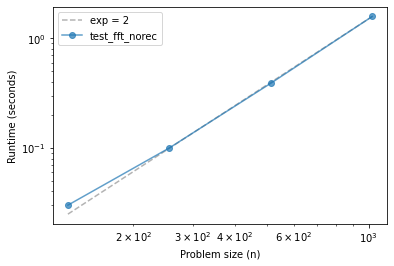

In [19]:
ns, ts = run_timing_test(test_fft_norec, start_at=5)
plot_timing_test(ns, ts, 'test_fft_norec', exp=2)

**Exercise:**  Starting with `fft_norec`, write a function called `fft_rec` that's fully recursive; that is, instead of using `dft` to compute the DFTs of the halves, it should use `fft_rec`.

You will need a base case to avoid an infinite recursion.  You have two options:

1) The DFT of an array with length 1 is the array itself.

2) If the parameter, `x`, is smaller than some threshold length, you could use DFT.

Use `test_fft_rec`, below, to check the performance of your function.

In [20]:
# Solution

def fft_rec(x):
    N = len(x)
    if N == 1:
        return x
    
    E = fft_rec(x[::2])
    O = fft_rec(x[1::2])
    return merge(E, O)

In [21]:
fft_rec(x)

array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In [22]:
def test_fft_rec(N):
    x = np.random.normal(size=N)
    spectrum = fft_rec(x)

In [23]:
%time test_fft_rec(512)

CPU times: user 8.36 ms, sys: 42 µs, total: 8.4 ms
Wall time: 7.92 ms


1024 0.019999999999999574
2048 0.030000000000001137
4096 0.049999999999998934
8192 0.11000000000000121
16384 0.22999999999999865
32768 0.45000000000000107
65536 0.9000000000000004
131072 1.83


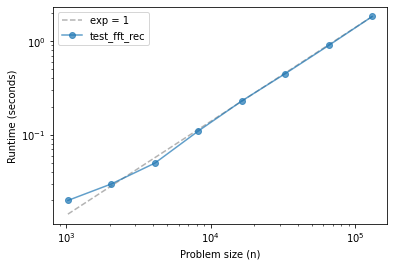

In [24]:
ns, ts = run_timing_test(test_fft_rec)
plot_timing_test(ns, ts, 'test_fft_rec', exp=1)

If things go according to plan, your FFT implementation should be faster than `dft` and `fft_norec`, and over a range of problem sizes, it might be indistinguishable from linear.

*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)